In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Gaussian process regression (GPR) on Mauna Loa CO2 data

The data consists of the monthly average atmospheric
CO2 concentrations (in parts per million by volume (ppm)) collected at the
Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to
model the CO2 concentration as a function of the time $t$ and extrapolate
for years after 2001.

.. topic: References

    .. [RW2006] [Rasmussen, Carl Edward.
       "Gaussian processes in machine learning."
       Summer school on machine learning. Springer, Berlin, Heidelberg, 2003](http://www.gaussianprocess.org/gpml/chapters/RW.pdf).


### Credits
Based on work done by:
- Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
- Guillaume Lemaitre <g.lemaitre58@gmail.com> <br>
License: BSD 3 clause

## Build the dataset

We will derive a dataset from the Mauna Loa Observatory that collected air
samples. We are interested in estimating the concentration of CO2 and
extrapolate it for further year. First, we load the original dataset available
in OpenML.



In [32]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958.0,3.0,29.0,4.0,0.0,MLO,316.1
1,1958.0,4.0,5.0,6.0,0.0,MLO,317.3
2,1958.0,4.0,12.0,4.0,0.0,MLO,317.6
3,1958.0,4.0,19.0,6.0,0.0,MLO,317.5
4,1958.0,4.0,26.0,2.0,0.0,MLO,316.4


#### Use the 'year', 'month', 'day'  columns in pd.to_datetime to create a date index and select only the CO2 column.



In [33]:
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[['year', 'month' , 'day']])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


#### What are the earliest and latest data points?

In [34]:
print("earliest:" , co2_data.index.min())
print("latest:" , co2_data.index.max())

earliest: 1958-03-29 00:00:00
latest: 2001-12-29 00:00:00


We see that we get CO2 concentration for some days from March, 1958 to
December, 2001. 
#### Make a lineplot 



Text(0.5, 1.0, 'Raw air samples measurements from the Mauna Loa Observatory')

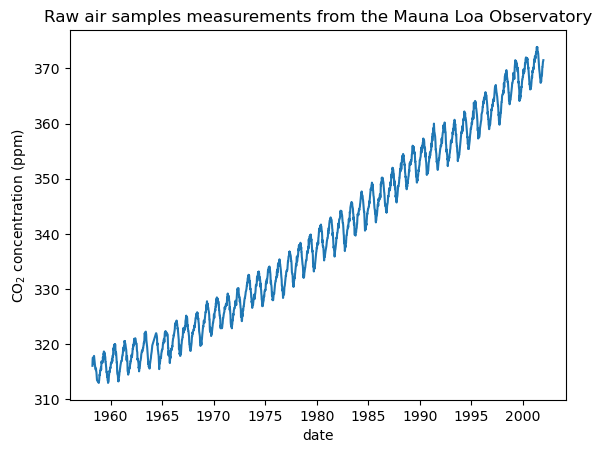

In [35]:
sns.lineplot(data = co2_data , x=co2_data.index , y='co2')
plt.ylabel("CO$_2$ concentration (ppm)")
plt.title("Raw air samples measurements from the Mauna Loa Observatory")

#### Preprocess the dataset by taking a monthly average and drop months for which no measurements were collected. 



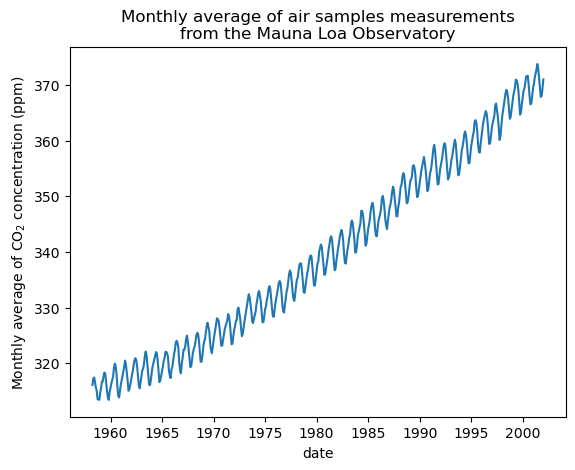

In [36]:
co2_data = co2_data.resample("M").mean().dropna(axis="index")
sns.lineplot(data = co2_data , x=co2_data.index , y='co2')
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_=plt.title(    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory")



#### Make a numeric date column by adding  month divided by 12 to year

In [37]:
co2_data['date'] = co2_data.index.year + co2_data.index.month / 12
co2_data.head()

,co2,date
date,,
1958-03-31,316.100000,1958.250000
1958-04-30,317.200000,1958.333333
1958-05-31,317.433333,1958.416667
1958-07-31,315.625000,1958.583333
1958-08-31,314.950000,1958.666667


#### Split into train and test sets by 70:30 rule

In [38]:
from sklearn.model_selection import train_test_split
X = co2_data[['date']]
y = co2_data['co2']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=10)

#### Start off with linear regression just to see how it does.


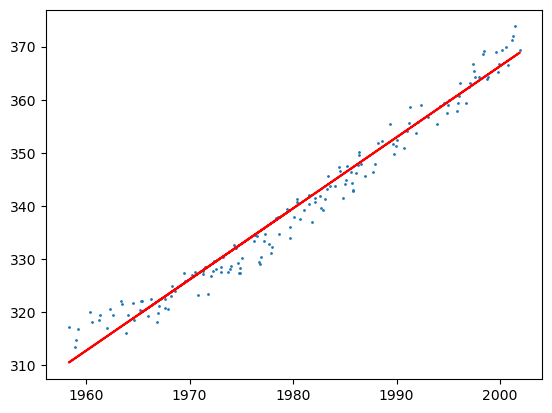

In [39]:
from sklearn.linear_model import LinearRegression
lreg = LinearRegression()
lreg.fit(Xtrain, ytrain)
y_pred = lreg.predict(Xtest)
plt.plot(Xtest, y_pred,c='r')
plt.scatter(Xtest,ytest,s=1)

#### Make residual plot 

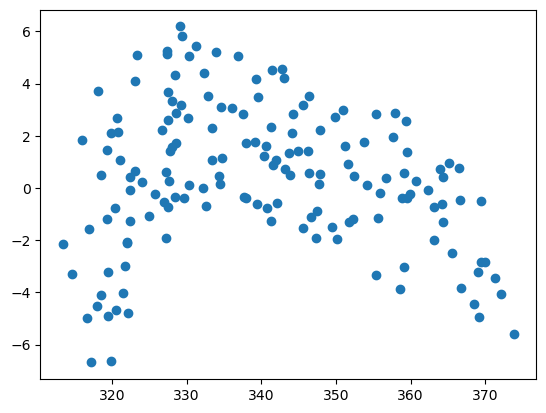

In [40]:
plt.scatter(ytest , y_pred - ytest)

In [41]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest,y_pred)

7.537467369157967

## Gaussian Process Regression

### Design the proper kernel




#### Start with RBF kernel.  We want the trend to be smooth so let length_scale=40.0. Try scale parameter =5**2

In [42]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 5**2*RBF(length_scale=40)

#### We will need a periodic kernel too.
The seasonal variation is explained by the periodic exponential sine squared
kernel with a periodicity of 1 year. The length-scale of this periodic
component, controlling its smoothness, is a free parameter. Let's start with length_scale=1.0


In [43]:
from sklearn.gaussian_process.kernels import ExpSineSquared
seasonal_kernel = ExpSineSquared(periodicity= 1.0 , length_scale = 1.0)

In [44]:
# add kernels
co2_kernel = long_term_trend_kernel + seasonal_kernel
co2_kernel

5**2 * RBF(length_scale=40) + ExpSineSquared(length_scale=1, periodicity=1)

## Model fitting 

#### We want the y data to have zero mean. Subtract the mean from the y values


In [45]:
y_mean = y.mean()
y_new = y- y_mean


#### Split train/test. We will only train on 10% of the data. Use random_state = 10

In [46]:

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y_new,test_size=0.9,random_state=10)

from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=co2_kernel)
gp.fit(Xtrain, ytrain)


GaussianProcessRegressor(kernel=5**2 * RBF(length_scale=40) + ExpSineSquared(length_scale=1, periodicity=1))

#### Predict on test set. We need the mean predictions and also the standard deviation.

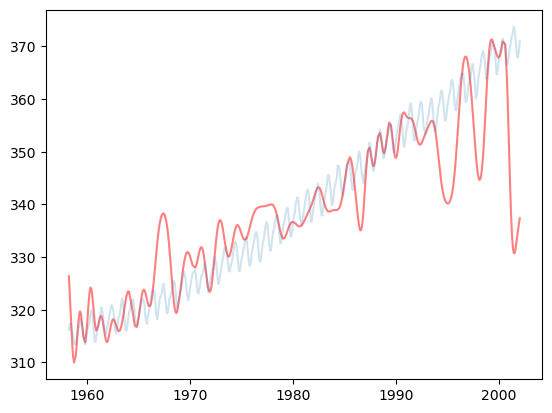

In [49]:
#sort index
Xtest = Xtest.sort_index()
ytest = ytest.sort_index()
#predict on Xtest. 
mean_y_pred,std_y_pred = gp.predict(Xtest,return_std=True)
# Before we plot the predictions add the mean back to the y predictions
mean_y_pred += y_mean
# Make line plot showing the mean prediction and the actual y value
plt.plot(Xtest,mean_y_pred , c='r' , alpha=0.5)
plt.plot(Xtest,ytest + y_mean , alpha =0.2)


In [50]:
mean_squared_error(ytest+y_mean, mean_y_pred)

81.23869407949525

In [51]:
gp.kernel_

14.8**2 * RBF(length_scale=0.481) + ExpSineSquared(length_scale=29.2, periodicity=0.0259)

#### We got very bad results. We see that sklearn has tried to optimize the periodicity but we can see in the data that this should stay close to 1

2.424140501968796


38.6**2 * RBF(length_scale=44.2) + 2.27**2 * RBF(length_scale=2.86) * ExpSineSquared(length_scale=0.0493, periodicity=1)

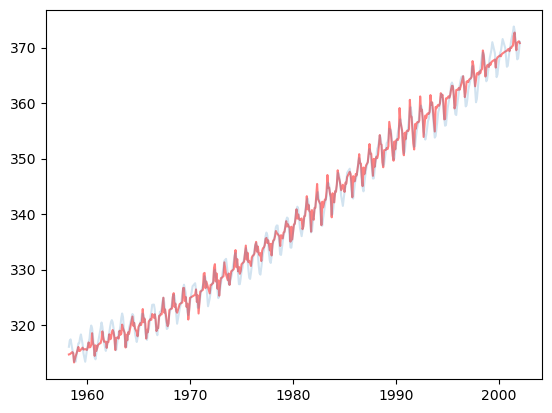

In [55]:
#fix periodicity so that it can't be changed. Muliplying expsinesquared by RBF allows more flexibility
#This is known as a locally periodic kernel.
seasonal_kernel = (1.0**2* RBF(length_scale=1)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed"))




# add kernels
co2_kernel = long_term_trend_kernel + seasonal_kernel
#make new model fit
gp = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gp.fit(Xtrain, ytrain)
#predict
mean_y_pred,std_y_pred = gp.predict(Xtest,return_std=True)
# Before we plot the predictions add the mean back to the y predictions
mean_y_pred += y_mean
# Make line plot showing the mean prediction and the actual y value
plt.plot(Xtest, mean_y_pred,c='r',alpha=0.5)
plt.plot(Xtest,ytest+y_mean,alpha=0.2)

print(mean_squared_error(ytest+y_mean, mean_y_pred))
gp.kernel_

This is looking a lot better, but the periodic kernel tried to compensate for irregularities in the data causing inaccuracies in the amplitude.

####   Maybe we can improve even more by using a RationalQuadratic Kernel. 
This type of kernel is used when there are irregularities.

In [56]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)


0.23235904155715775


46.2**2 * RBF(length_scale=51.9) + 2.16**2 * RBF(length_scale=545) * ExpSineSquared(length_scale=0.0158, periodicity=1) + 5.74**2 * RationalQuadratic(alpha=0.00114, length_scale=1.09)

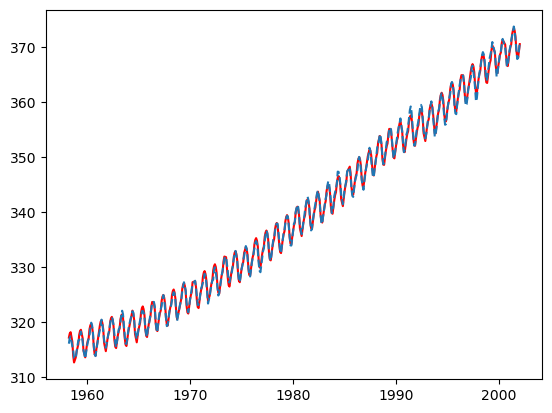

In [59]:
# add kernels
co2_kernel = long_term_trend_kernel + seasonal_kernel + irregularities_kernel
#make new model fit
gp = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gp.fit(Xtrain, ytrain)
#predict
mean_y_pred,std_y_pred = gp.predict(Xtest,return_std=True)
# Before we plot the predictions add the mean back to the y predictions
mean_y_pred += y_mean
# Make line plot showing the mean prediction and the actual y value
plt.plot(Xtest, mean_y_pred,c='r')
plt.plot(Xtest,ytest+y_mean,linestyle="dashed")

print(mean_squared_error(ytest+y_mean, mean_y_pred))
gp.kernel_

Now, we will use the Gaussian process to predict on future data to see the extrapolation done by the model.

#### Create synthetic data from 1958 to the current month. 

In [60]:
import datetime

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_future = pd.DataFrame({'date':np.linspace(start=1958, stop=current_month, num=1000)})
#Use gp model to predict y at all these X values
mean_y_pred, std_y_pred = gp.predict(X_future, return_std=True)
mean_y_pred += y_mean

#### Plot all original data and predicted data into the future on the same graph and add confidence bounds of 2 standard deviations

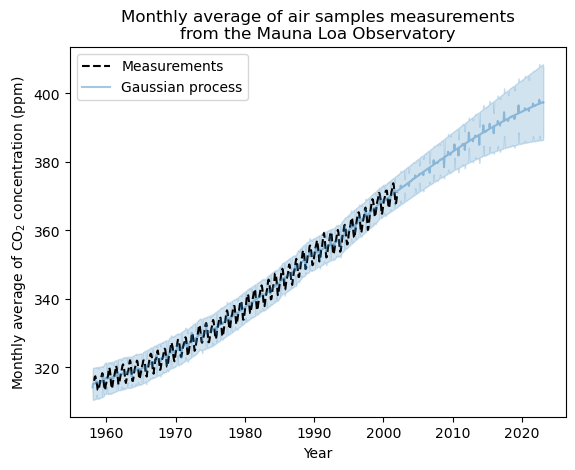

In [64]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_future, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_future.to_numpy().flatten(),
    mean_y_pred - 2*std_y_pred,
    mean_y_pred + 2*std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)